# Discrete Event Simulation: Dining Philosophers



**Task overview**
- 5 philosophers sitting around round table
- 5 chopsticks (one between each pair of philosophers)
- Each philosopher needs 2 chopsticks to eat
- States: Thinking -> Hungry -> Eating -> Thinking

**Tasks implemented:**
1. Basic simulation (100 time units)
2. Deadlock detection
3. Deadlock prevention (priority ordering + timeout strategies)

In [20]:
import heapq
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from dataclasses import dataclass, field
from typing import List, Optional, Tuple
from enum import Enum
from collections import deque

random.seed(54)
np.random.seed(54)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Core Classes and Data Structures

In [21]:
class PhilosopherState(Enum):
    """States philosopher can be in"""
    THINKING = "thinking"
    HUNGRY = "hungry"
    EATING = "eating"


class EventType(Enum):
    """Types of events in the simulation"""
    FINISH_THINKING = "finish_thinking"
    TRY_ACQUIRE_CHOPSTICKS = "try_acquire_chopsticks"
    FINISH_EATING = "finish_eating"
    TIMEOUT_RELEASE = "timeout_release"


@dataclass(order=True)
class Event:
    """Event in the discrete event simulation"""
    time: float
    event_type: EventType = field(compare=False)
    philosopher_id: int = field(compare=False)
    generation: int = field(compare=False, default=0)


class Chopstick:
    """Represents a chopstick resource"""
    def __init__(self, id: int):
        self.id = id
        self.held_by: Optional[int] = None

    def is_available(self) -> bool:
        return self.held_by is None

    def acquire(self, philosopher_id: int) -> bool:
        if self.is_available():
            self.held_by = philosopher_id
            return True
        return False

    def release(self):
        self.held_by = None


class Philosopher:
    """Represents a philosopher with state and behavior"""
    def __init__(self, id: int, left: int, right: int, deadlock_prone: bool = False):
        self.id = id
        self.state = PhilosopherState.THINKING
        self.left_chopstick_id = left
        self.right_chopstick_id = right
        self.held_chopsticks: List[int] = []
        self.eat_count = 0
        self.total_thinking_time = 0.0
        self.total_eating_time = 0.0
        self.total_hungry_time = 0.0
        self.last_state_change = 0.0
        self.last_ate_time = 0.0
        self.attempt_start_time = None
        self.generation = 0
        self.deadlock_prone = deadlock_prone

    def get_thinking_time(self):
        return 0.0 if self.deadlock_prone else random.expovariate(1 / 5)

    def get_eating_time(self):
        return random.uniform(0.3, 0.8) if self.deadlock_prone else random.expovariate(1 / 3)

    def get_retry_time(self):
        return 0.2 if self.deadlock_prone else random.uniform(0.1, 0.5)

    def update_state_time(self, now):
        dt = now - self.last_state_change
        if self.state == PhilosopherState.THINKING:
            self.total_thinking_time += dt
        elif self.state == PhilosopherState.HUNGRY:
            self.total_hungry_time += dt
        elif self.state == PhilosopherState.EATING:
            self.total_eating_time += dt
        self.last_state_change = now


## Simulation Engine

In [22]:
class DiningPhilosophersSimulation:
    """Discrete event simulation of dining philosophers"""

    def __init__(
        self,
        num_philosophers: int = 5,
        deadlock_detection: bool = False,
        prevention_strategy: str = "none",
        starvation_prevention: bool = False,
        timeout_duration: float = 2.0,
        deadlock_prone: bool = False,
        synchronized_start: bool = False,
        force_deadlock_demo: bool = False,
        halt_on_deadlock: bool = False
    ):
        """
        Initialize simulation

        Args:
            num_philosophers: number of philosophers (by default 5)
            deadlock_detection: enable deadlock detection
            prevention_strategy: 'none', 'priority', 'timeout'
            timeout_duration: timeout for releasing chopsticks
            deadlock_prone: use tighter think/eat times to increase contention
            synchronized_start: have all philosophers start hungry at t=0 (for detection demo)
            force_deadlock_demo: force everyone to hold left chopstick at t=0 (demo only)
            halt_on_deadlock: if True, stop simulation on first deadlock (default: False)
        """
        self.num_philosophers = num_philosophers
        self.current_time = 0.0
        self.event_queue = []
        self.deadlock_detection = deadlock_detection
        self.prevention_strategy = prevention_strategy
        self.starvation_prevention = starvation_prevention
        self.timeout_duration = timeout_duration
        self.deadlock_prone = deadlock_prone
        self.synchronized_start = synchronized_start
        self.force_deadlock_demo = force_deadlock_demo
        self.in_deadlock = False       # latch to avoid multiple counts per deadlock
        self.halt_on_deadlock = halt_on_deadlock
        self.halted = False            # track if simulation was halted

        # queues for starvation prevention
        self.hungry_queue = deque()
        self.in_queue = set()

        # stats
        self.deadlock_count = 0
        self.deadlock_times = []
        self.event_log = []

        # resources
        self.chopsticks = [Chopstick(i) for i in range(num_philosophers)]

        # philosophers
        self.philosophers = []
        for i in range(num_philosophers):
            left = i
            right = (i + 1) % num_philosophers
            self.philosophers.append(Philosopher(i, left, right, deadlock_prone))

        if synchronized_start:
            # everyone hungry at t=0, no chopsticks yet
            for phil in self.philosophers:
                phil.state = PhilosopherState.HUNGRY
                if self.starvation_prevention and phil.id not in self.in_queue:
                    self.hungry_queue.append(phil.id)
                    self.in_queue.add(phil.id)
                phil.last_state_change = 0.0
                self.schedule_event(Event(0.0, EventType.TRY_ACQUIRE_CHOPSTICKS, phil.id, phil.generation))
        else:
            # Normal initialization: everyone starts thinking
            for phil in self.philosophers:
                thinking_time = phil.get_thinking_time()
                self.schedule_event(Event(thinking_time, EventType.FINISH_THINKING, phil.id))

        # Optional demo: force immediate circular wait (everyone holds left)
        if force_deadlock_demo:
            for phil in self.philosophers:
                phil.state = PhilosopherState.HUNGRY
                if self.starvation_prevention and phil.id not in self.in_queue:
                    self.hungry_queue.append(phil.id)
                    self.in_queue.add(phil.id)
                phil.held_chopsticks = [phil.left_chopstick_id]
                self.chopsticks[phil.left_chopstick_id].held_by = phil.id
                phil.last_state_change = 0.0
                self.schedule_event(Event(0.0, EventType.TRY_ACQUIRE_CHOPSTICKS, phil.id, phil.generation))

    def schedule_event(self, event: Event):
        """Add event to priority queue"""
        heapq.heappush(self.event_queue, event)

    def log_event(self, description: str):
        """Log simulation event"""
        self.event_log.append({
            'time': self.current_time,
            'description': description
        })

    def get_chopstick_order(self, philosopher: Philosopher) -> Tuple[int, int]:
        """Get chopstick acquisition order based on prevention strategy"""
        left = philosopher.left_chopstick_id
        right = philosopher.right_chopstick_id
        if self.prevention_strategy == "priority":
            return (min(left, right), max(left, right))
        return (left, right)

    def try_acquire_chopsticks(self, philosopher: Philosopher) -> bool:
        """Two-phase acquire: take first chopstick, then try for second later"""
        first_id, second_id = self.get_chopstick_order(philosopher)
        first_chopstick = self.chopsticks[first_id]
        second_chopstick = self.chopsticks[second_id]

        has_first = first_id in philosopher.held_chopsticks
        has_second = second_id in philosopher.held_chopsticks

        # Step 1: grab the first if not already holding it
        if not has_first:
            if first_chopstick.acquire(philosopher.id):
                philosopher.held_chopsticks.append(first_id)
            else:
                return False
            # give everyone time to grab their first chopstick
            return False

        # Step 2: try to grab the second
        if not has_second:
            if second_chopstick.acquire(philosopher.id):
                philosopher.held_chopsticks.append(second_id)
                return True
            else:
                if self.prevention_strategy == "timeout" and philosopher.attempt_start_time is None:
                    philosopher.attempt_start_time = self.current_time
                    self.schedule_event(Event(
                        self.current_time + self.timeout_duration,
                        EventType.TIMEOUT_RELEASE,
                        philosopher.id,
                        philosopher.generation
                    ))
                return False

        # Already holding both
        return True

    def release_chopsticks(self, philosopher: Philosopher):
        """Release all held chopsticks"""
        for chopstick_id in philosopher.held_chopsticks:
            self.chopsticks[chopstick_id].release()
        philosopher.held_chopsticks = []
        philosopher.attempt_start_time = None
        philosopher.generation += 1  # invalidate pending events for this philosopher

    def check_deadlock(self) -> bool:
        """
        Check if system is in deadlock.
        Deadlock = all philosophers hungry AND each holds exactly one chopstick (circular wait).
        This is a structural condition — detected immediately, no time delay needed.
        """
        if not self.deadlock_detection:
            return False

        hungry_count = sum(1 for p in self.philosophers if p.state == PhilosopherState.HUNGRY)
        if hungry_count == self.num_philosophers:
            holding_one = sum(1 for p in self.philosophers if len(p.held_chopsticks) == 1)
            if holding_one == self.num_philosophers:
                return True  # circular wait confirmed
        return False

    def kick_front(self):
        if not self.starvation_prevention:
            return
        if not self.hungry_queue:
            return
        fid = self.hungry_queue[0]
        f = self.philosophers[fid]
        self.schedule_event(Event(self.current_time, EventType.TRY_ACQUIRE_CHOPSTICKS, fid, f.generation))

    def handle_finish_thinking(self, philosopher: Philosopher):
        philosopher.update_state_time(self.current_time)
        philosopher.state = PhilosopherState.HUNGRY

        if self.starvation_prevention:
            if philosopher.id not in self.in_queue:
                self.hungry_queue.append(philosopher.id)
                self.in_queue.add(philosopher.id)

        self.log_event(f"Philosopher {philosopher.id} is now HUNGRY")
        self.schedule_event(Event(self.current_time, EventType.TRY_ACQUIRE_CHOPSTICKS, philosopher.id, philosopher.generation))
        self.kick_front()

    def handle_try_acquire(self, philosopher: Philosopher):
        if philosopher.state != PhilosopherState.HUNGRY:
            return

        success = self.try_acquire_chopsticks(philosopher)

        if success:
            philosopher.update_state_time(self.current_time)
            philosopher.state = PhilosopherState.EATING
            if self.starvation_prevention:
                if self.hungry_queue and self.hungry_queue[0] == philosopher.id:
                    self.hungry_queue.popleft()
                    self.in_queue.discard(philosopher.id)
                else:
                    # safety: remove if present elsewhere (shouldn't happen)
                    if philosopher.id in self.in_queue:
                        self.in_queue.discard(philosopher.id)
                        try:
                            self.hungry_queue.remove(philosopher.id)
                        except ValueError:
                            pass
            philosopher.eat_count += 1
            philosopher.last_ate_time = self.current_time
            self.in_deadlock = False  # clear latch on progress
            self.log_event(f"Philosopher {philosopher.id} is now EATING (count: {philosopher.eat_count})")
            eating_time = philosopher.get_eating_time()
            self.schedule_event(Event(self.current_time + eating_time, EventType.FINISH_EATING, philosopher.id, philosopher.generation))
        else:
            retry_time = philosopher.get_retry_time()
            self.schedule_event(Event(self.current_time + retry_time, EventType.TRY_ACQUIRE_CHOPSTICKS, philosopher.id, philosopher.generation))

    def handle_finish_eating(self, philosopher: Philosopher):
        philosopher.update_state_time(self.current_time)
        self.release_chopsticks(philosopher)
        philosopher.state = PhilosopherState.THINKING
        self.in_deadlock = False  # clear latch on progress
        self.log_event(f"Philosopher {philosopher.id} is now THINKING")
        thinking_time = philosopher.get_thinking_time()
        self.schedule_event(Event(self.current_time + thinking_time, EventType.FINISH_THINKING, philosopher.id))
        self.kick_front()

    def handle_timeout_release(self, philosopher: Philosopher):
        if philosopher.state == PhilosopherState.HUNGRY and len(philosopher.held_chopsticks) > 0:
            self.log_event(f"Philosopher {philosopher.id} TIMEOUT - releasing chopsticks")
            self.release_chopsticks(philosopher)
            self.in_deadlock = False  # clear latch after forced release
            retry_time = philosopher.get_retry_time()
            self.schedule_event(Event(self.current_time + retry_time, EventType.TRY_ACQUIRE_CHOPSTICKS, philosopher.id, philosopher.generation))
            self.kick_front()

    def process_event(self, event: Event):
        self.current_time = event.time
        philosopher = self.philosophers[event.philosopher_id]

        if event.event_type == EventType.FINISH_THINKING:
            self.handle_finish_thinking(philosopher)

        elif event.event_type == EventType.TRY_ACQUIRE_CHOPSTICKS:
            if self.starvation_prevention:
                if not self.hungry_queue:
                    return

                front_id = self.hungry_queue[0]
                front = self.philosophers[front_id]

                # If front is no longer hungry, drop it (cleanup)
                if front.state != PhilosopherState.HUNGRY:
                    self.hungry_queue.popleft()
                    self.in_queue.discard(front_id)
                    self.kick_front()
                    return

                # Only the front philosopher is allowed to try
                if event.philosopher_id != front_id:
                    return
                if event.generation != front.generation:
                    return
                self.handle_try_acquire(front)
            else:
                # Baseline: the philosopher tied to this event tries
                if event.generation == philosopher.generation:  # ignore stale retries
                    self.handle_try_acquire(philosopher)

        elif event.event_type == EventType.FINISH_EATING:
            if event.generation == philosopher.generation:
                self.handle_finish_eating(philosopher)

        elif event.event_type == EventType.TIMEOUT_RELEASE:
            if event.generation == philosopher.generation:  # ignore stale timeouts
                self.handle_timeout_release(philosopher)

        if self.check_deadlock():
            if not self.in_deadlock:
                self.in_deadlock = True
                self.deadlock_count += 1
                self.deadlock_times.append(self.current_time)
                self.log_event(f"DEADLOCK DETECTED! (occurrence #{self.deadlock_count})")

                # If halt_on_deadlock is enabled, mark as halted and stop
                if self.halt_on_deadlock:
                    self.halted = True
                    self.log_event("SIMULATION HALTED DUE TO DEADLOCK")
                    return

                # Break deadlock: find the philosopher waiting longest,
                # then release the neighbor who holds their needed chopstick.
                # This lets the longest-waiting philosopher eat next.
                longest_hungry = None
                max_wait = -1.0
                for p in self.philosophers:
                    if p.state == PhilosopherState.HUNGRY:
                        wait_time = self.current_time - p.last_state_change
                        if wait_time > max_wait or (wait_time == max_wait and (longest_hungry is None or p.id < longest_hungry.id)):
                            max_wait = wait_time
                            longest_hungry = p

                if longest_hungry:
                    needed_chopstick_id = None
                    for cid in (longest_hungry.left_chopstick_id, longest_hungry.right_chopstick_id):
                        if cid not in longest_hungry.held_chopsticks:
                            needed_chopstick_id = cid
                            break

                    if needed_chopstick_id is not None:
                        holder_id = self.chopsticks[needed_chopstick_id].held_by
                        if holder_id is not None:
                            holder = self.philosophers[holder_id]
                            self.log_event(
                                f"Breaking deadlock: Philosopher {holder.id} releases chopstick {needed_chopstick_id} "
                                f"for Philosopher {longest_hungry.id}"
                            )
                            self.release_chopsticks(holder)
                            self.in_deadlock = False  # allow re-detection if deadlock reforms immediately
                            retry_time = holder.get_retry_time()
                            self.schedule_event(Event(
                                self.current_time + retry_time,
                                EventType.TRY_ACQUIRE_CHOPSTICKS,
                                holder.id,
                                holder.generation
                            ))
                            self.kick_front()
        else:
            self.in_deadlock = False

    def run(self, max_time: float = 100.0):
        while self.event_queue and self.event_queue[0].time <= max_time:
            if self.halted:
                break
            event = heapq.heappop(self.event_queue)
            self.process_event(event)

        for phil in self.philosophers:
            phil.update_state_time(max_time if not self.halted else self.current_time)

        if not self.halted:
            self.current_time = max_time

    def print_statistics(self):
        print(f"Simulation Statistics (Time: 0 to {self.current_time:.2f})")
        print(f"Strategy: {self.prevention_strategy.upper()}")

        if self.prevention_strategy == "timeout":
            print(f"Timeout Duration: {self.timeout_duration}")

        if self.deadlock_prone:
            print("Deadlock-prone timing: tighter think/eat times")

        if self.synchronized_start:
            print("Synchronized start: all hungry at t=0")

        if self.halted:
            print("*** SIMULATION HALTED DUE TO DEADLOCK ***")

        print()
        print(f"{'Philosopher':<12} {'Eat Count':<12} {'Thinking %':<15} {'Hungry %':<15} {'Eating %':<15}")

        for phil in self.philosophers:
            think_pct = (phil.total_thinking_time / self.current_time) * 100 if self.current_time > 0 else 0
            hungry_pct = (phil.total_hungry_time / self.current_time) * 100 if self.current_time > 0 else 0
            eat_pct = (phil.total_eating_time / self.current_time) * 100 if self.current_time > 0 else 0
            print(f"{phil.id:<12} {phil.eat_count:<12} {think_pct:<15.1f} {hungry_pct:<15.1f} {eat_pct:<15.1f}")

        print()
        total_eats = sum(p.eat_count for p in self.philosophers)
        avg_eats = total_eats / self.num_philosophers
        print(f"Total Eats: {total_eats}")
        print(f"Average Eats per Philosopher: {avg_eats:.2f}")

        if self.deadlock_detection:
            print(f"\nDeadlocks Detected: {self.deadlock_count}")
            if self.deadlock_times:
                preview = self.deadlock_times[:5]
                suffix = "..." if len(self.deadlock_times) > 5 else ""
                print(f"Deadlock Times: {preview}{suffix}")


# Task 1: Basic Simulation

Simulate 5 philosophers for 100 time units and track eating counts.

In [23]:
random.seed(54)
np.random.seed(54)
sim1 = DiningPhilosophersSimulation(
    num_philosophers=5,
    deadlock_detection=False,
    prevention_strategy="none"
)
sim1.run(max_time=120.0)
sim1.print_statistics()

Simulation Statistics (Time: 0 to 120.00)
Strategy: NONE

Philosopher  Eat Count    Thinking %      Hungry %        Eating %       
0            4            58.9            30.5            10.5           
1            9            32.8            49.2            18.0           
2            8            35.9            47.7            16.4           
3            7            44.9            21.4            33.7           
4            7            44.7            31.2            24.1           

Total Eats: 35
Average Eats per Philosopher: 7.00


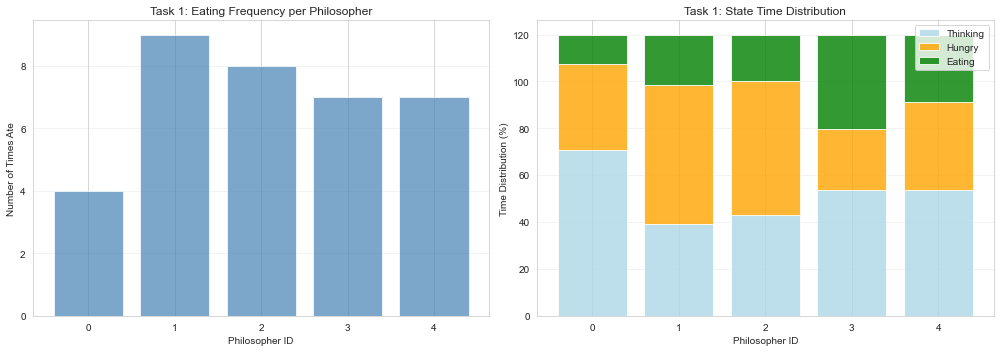

In [24]:
# task 1 results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# bar chart of eat counts
eat_counts = [p.eat_count for p in sim1.philosophers]
axes[0].bar(range(5), eat_counts, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Philosopher ID')
axes[0].set_ylabel('Number of Times Ate')
axes[0].set_title('Task 1: Eating Frequency per Philosopher')
axes[0].set_xticks(range(5))
axes[0].grid(axis='y', alpha=0.3)

# bar chart of time distribution
thinking_pct = [p.total_thinking_time / 100 * 100 for p in sim1.philosophers]
hungry_pct = [p.total_hungry_time / 100 * 100 for p in sim1.philosophers]
eating_pct = [p.total_eating_time / 100 * 100 for p in sim1.philosophers]

x = np.arange(5)
axes[1].bar(x, thinking_pct, label='Thinking', color='lightblue', alpha=0.8)
axes[1].bar(x, hungry_pct, bottom=thinking_pct, label='Hungry', color='orange', alpha=0.8)
axes[1].bar(x, eating_pct, bottom=np.array(thinking_pct) + np.array(hungry_pct), label='Eating', color='green', alpha=0.8)
axes[1].set_xlabel('Philosopher ID')
axes[1].set_ylabel('Time Distribution (%)')
axes[1].set_title('Task 1: State Time Distribution')
axes[1].set_xticks(range(5))
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Task 2: Deadlock Detection

Enable deadlock detection to identify when all philosophers are hungry with one chopstick each.

In [25]:
sim2_halt = DiningPhilosophersSimulation(
    num_philosophers=5,
    deadlock_detection=True,
    prevention_strategy="none",
    deadlock_prone=True,
    synchronized_start=True,
    halt_on_deadlock=True
)

sim2_halt.run(max_time=120.0)
sim2_halt.print_statistics()

Simulation Statistics (Time: 0 to 0.00)
Strategy: NONE
Deadlock-prone timing: tighter think/eat times
Synchronized start: all hungry at t=0
*** SIMULATION HALTED DUE TO DEADLOCK ***

Philosopher  Eat Count    Thinking %      Hungry %        Eating %       
0            0            0.0             0.0             0.0            
1            0            0.0             0.0             0.0            
2            0            0.0             0.0             0.0            
3            0            0.0             0.0             0.0            
4            0            0.0             0.0             0.0            

Total Eats: 0
Average Eats per Philosopher: 0.00

Deadlocks Detected: 1
Deadlock Times: [0.0]


In [26]:
sim2 = DiningPhilosophersSimulation(
    num_philosophers=5,
    deadlock_detection=True,
    prevention_strategy="none",
    deadlock_prone=True,
    synchronized_start=True
)

sim2.run(max_time=120.0)
sim2.print_statistics()

Simulation Statistics (Time: 0 to 120.00)
Strategy: NONE
Deadlock-prone timing: tighter think/eat times
Synchronized start: all hungry at t=0

Philosopher  Eat Count    Thinking %      Hungry %        Eating %       
0            29           0.0             86.9            13.1           
1            29           0.0             87.2            12.8           
2            28           0.0             86.2            13.8           
3            28           0.0             87.4            12.6           
4            28           0.0             86.9            13.1           

Total Eats: 142
Average Eats per Philosopher: 28.40

Deadlocks Detected: 187
Deadlock Times: [0.0, 0.8, 1.7999999999999998, 2.8000000000000003, 3.800000000000001]...


In [27]:
print("\nSample Event Log (first 30 events):")
print(f"{'Time':<10} {'Event'}")

for event in sim2.event_log[:30]:
    print(f"{event['time']:<10.2f} {event['description']}")

if sim2.deadlock_count > 0:
    print(f"\n\nDEADLOCK EVENTS (Total: {sim2.deadlock_count}):")
    deadlock_events = [
        e for e in sim2.event_log
        if 'DEADLOCK' in e['description']
    ]

    for event in deadlock_events[:10]:
        print(f"{event['time']:<10.2f} {event['description']}")


Sample Event Log (first 30 events):
Time       Event
0.00       DEADLOCK DETECTED! (occurrence #1)
0.00       Breaking deadlock: Philosopher 1 releases chopstick 1 for Philosopher 0
0.20       Philosopher 0 is now EATING (count: 1)
0.62       Philosopher 0 is now THINKING
0.62       Philosopher 0 is now HUNGRY
0.80       DEADLOCK DETECTED! (occurrence #2)
0.80       Breaking deadlock: Philosopher 2 releases chopstick 2 for Philosopher 1
1.00       Philosopher 1 is now EATING (count: 1)
1.64       Philosopher 1 is now THINKING
1.64       Philosopher 1 is now HUNGRY
1.80       DEADLOCK DETECTED! (occurrence #3)
1.80       Breaking deadlock: Philosopher 3 releases chopstick 3 for Philosopher 2
2.00       Philosopher 2 is now EATING (count: 1)
2.77       Philosopher 2 is now THINKING
2.77       Philosopher 2 is now HUNGRY
2.80       DEADLOCK DETECTED! (occurrence #4)
2.80       Breaking deadlock: Philosopher 4 releases chopstick 4 for Philosopher 3
3.00       Philosopher 3 is now EATING (

# Task 3: Deadlock Prevention

Implement two prevention strategies:
1. **Priority Ordering**: Always pick lower chopstick first
2. **Timeout Strategy**: Release chopsticks after timeout and retry

In [28]:
# S1: Priority Ordering
random.seed(100)
np.random.seed(100)
sim3a = DiningPhilosophersSimulation(
    num_philosophers=5,
    deadlock_detection=True,
    prevention_strategy="priority",
    deadlock_prone=False,          # important for fairness
    synchronized_start=False       # avoid forced crowding
)

sim3a.run(max_time=120.0)
sim3a.print_statistics()

Simulation Statistics (Time: 0 to 120.00)
Strategy: PRIORITY

Philosopher  Eat Count    Thinking %      Hungry %        Eating %       
0            6            56.9            29.7            13.5           
1            12           30.3            27.4            42.3           
2            11           36.8            39.5            23.6           
3            11           60.8            24.0            15.2           
4            9            45.1            24.4            30.5           

Total Eats: 49
Average Eats per Philosopher: 9.80

Deadlocks Detected: 0


In [29]:
# S2: Timeout Strategy
random.seed(200)
np.random.seed(200)
sim3b = DiningPhilosophersSimulation(
    num_philosophers=5,
    deadlock_detection=True,
    prevention_strategy="timeout",
    timeout_duration=2.0,
    deadlock_prone=False,          # important for fairness
    synchronized_start=False
)

sim3b.run(max_time=120.0)
sim3b.print_statistics()

Simulation Statistics (Time: 0 to 120.00)
Strategy: TIMEOUT
Timeout Duration: 2.0

Philosopher  Eat Count    Thinking %      Hungry %        Eating %       
0            11           52.2            22.2            25.6           
1            11           51.5            19.7            28.8           
2            13           49.0            37.8            13.1           
3            12           52.0            18.6            29.4           
4            7            49.6            29.6            20.8           

Total Eats: 54
Average Eats per Philosopher: 10.80

Deadlocks Detected: 0


## Comparison of All Strategies

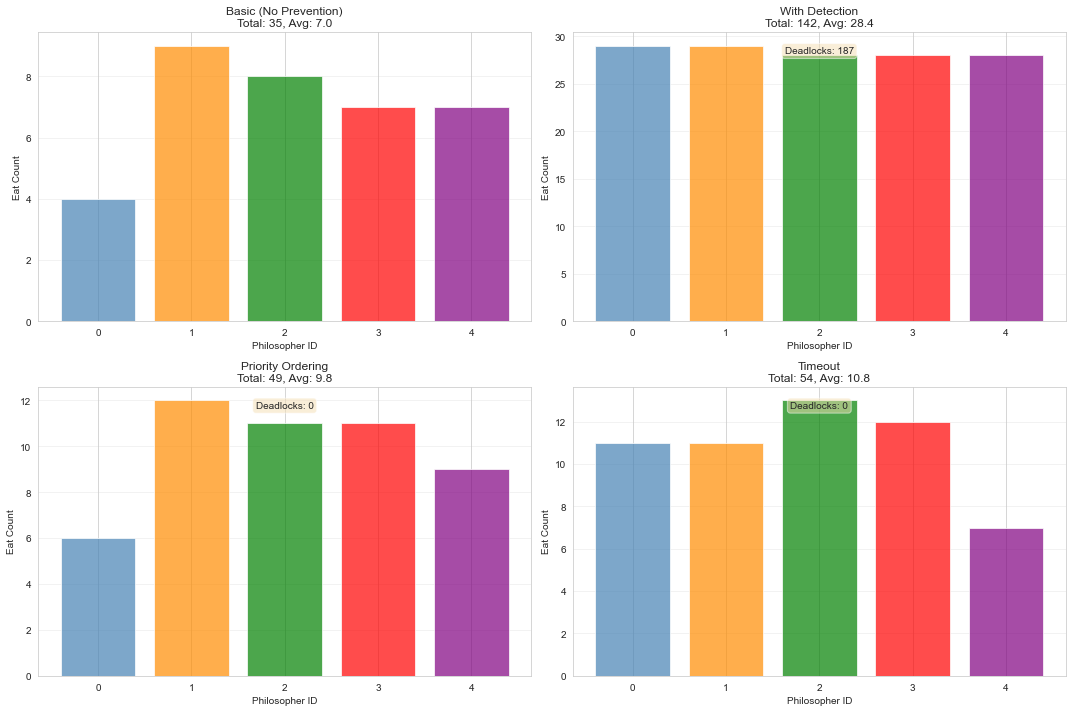

In [30]:
strategies = {
    'Basic (No Prevention)': sim1,
    'With Detection': sim2,
    'Priority Ordering': sim3a,
    'Timeout': sim3b
}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, sim) in enumerate(strategies.items()):
    eat_counts = [p.eat_count for p in sim.philosophers]
    axes[idx].bar(range(5), eat_counts, color=['steelblue', 'darkorange', 'green', 'red', 'purple'], alpha=0.7)
    axes[idx].set_xlabel('Philosopher ID')
    axes[idx].set_ylabel('Eat Count')
    axes[idx].set_title(f'{name}\nTotal: {sum(eat_counts)}, Avg: {sum(eat_counts)/5:.1f}')
    axes[idx].set_xticks(range(5))
    axes[idx].grid(axis='y', alpha=0.3)
    
    # deadlock count
    if hasattr(sim, 'deadlock_count') and sim.deadlock_detection:
        axes[idx].text(0.5, 0.95, f'Deadlocks: {sim.deadlock_count}', 
                      transform=axes[idx].transAxes, ha='center', va='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

In [31]:
summary_data = []
for name, sim in strategies.items():
    total_eats = sum(p.eat_count for p in sim.philosophers)
    avg_eats = total_eats / 5
    std_eats = np.std([p.eat_count for p in sim.philosophers])
    deadlocks = sim.deadlock_count if hasattr(sim, 'deadlock_count') else 'N/A'
    
    summary_data.append({
        'Strategy': name,
        'Total Eats': total_eats,
        'Avg Eats': f"{avg_eats:.2f}",
        'Std Dev': f"{std_eats:.2f}",
        'Deadlocks': deadlocks
    })

df_summary = pd.DataFrame(summary_data)
print("STRATEGY COMPARISON SUMMARY")
print(df_summary.to_string(index=False))

STRATEGY COMPARISON SUMMARY
             Strategy  Total Eats Avg Eats Std Dev  Deadlocks
Basic (No Prevention)          35     7.00    1.67          0
       With Detection         142    28.40    0.49        187
    Priority Ordering          49     9.80    2.14          0
              Timeout          54    10.80    2.04          0


# Task 4: Starvation Avoidance

Implementing a fairness mechanism so that all philosophers have a chance to eat.

Global Waiter: When a philosopher becomes hungry, put they are put in a queue. Only the philosopher at the front is allowed to try to acquire chopsticks. When they start eating, remove them from the queue.

In [34]:
# S4: Starvation Avoidance
random.seed(100)
np.random.seed(100)
sim4 = DiningPhilosophersSimulation(
    num_philosophers=5,
    deadlock_detection=True,
    prevention_strategy="priority",
    starvation_prevention=True,
    deadlock_prone=False,          # important for fairness
    synchronized_start=False,      # avoid forced crowding
)

sim4.run(max_time=120.0)
sim4.print_statistics()

Simulation Statistics (Time: 0 to 120.00)
Strategy: PRIORITY

Philosopher  Eat Count    Thinking %      Hungry %        Eating %       
0            7            40.6            43.3            16.1           
1            10           36.2            40.1            23.7           
2            9            33.9            45.3            20.7           
3            11           37.0            29.4            33.6           
4            7            41.4            49.0            9.7            

Total Eats: 44
Average Eats per Philosopher: 8.80

Deadlocks Detected: 0


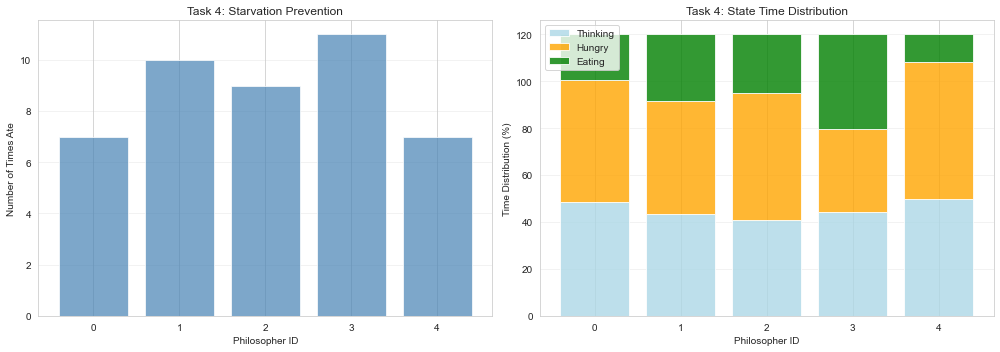

In [46]:
# task 4 results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# bar chart of eat counts
eat_counts = [p.eat_count for p in sim4.philosophers]
axes[0].bar(range(5), eat_counts, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Philosopher ID')
axes[0].set_ylabel('Number of Times Ate')
axes[0].set_title('Task 4: Starvation Prevention')
axes[0].set_xticks(range(5))
axes[0].grid(axis='y', alpha=0.3)

# bar chart of time distribution
thinking_pct = [p.total_thinking_time / 100 * 100 for p in sim4.philosophers]
hungry_pct = [p.total_hungry_time / 100 * 100 for p in sim4.philosophers]
eating_pct = [p.total_eating_time / 100 * 100 for p in sim4.philosophers]

x = np.arange(5)
axes[1].bar(x, thinking_pct, label='Thinking', color='lightblue', alpha=0.8)
axes[1].bar(x, hungry_pct, bottom=thinking_pct, label='Hungry', color='orange', alpha=0.8)
axes[1].bar(x, eating_pct, bottom=np.array(thinking_pct) + np.array(hungry_pct), label='Eating', color='green', alpha=0.8)
axes[1].set_xlabel('Philosopher ID')
axes[1].set_ylabel('Time Distribution (%)')
axes[1].set_title('Task 4: State Time Distribution')
axes[1].set_xticks(range(5))
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [37]:
def compute_statistics(sim):
    eat_counts = np.array([p.eat_count for p in sim.philosophers])
    hungry_times = np.array([p.total_hungry_time for p in sim.philosophers])
    eating_times = np.array([p.total_eating_time for p in sim.philosophers])

    stats = {
        "total_time": sim.current_time,
        "total_eats": eat_counts.sum(),
        "avg_eats": eat_counts.mean(),
        "eat_std": eat_counts.std(),
        "min_eats": eat_counts.min(),
        "max_eats": eat_counts.max(),

        "avg_hungry_time": hungry_times.mean(),
        "max_hungry_time": hungry_times.max(),

        "avg_eating_time": eating_times.mean(),

        "throughput": eat_counts.sum() / sim.current_time if sim.current_time > 0 else 0
    }

    return stats


def print_statistics(stats, title="Simulation Statistics"):
    print(f"\n{title}")
    print("-" * len(title))

    print(f"Total simulation time      : {stats['total_time']:.2f}")
    print(f"Total eats                 : {stats['total_eats']}")
    print(f"Average eats               : {stats['avg_eats']:.2f}")
    print(f"Eat count std deviation    : {stats['eat_std']:.2f}")
    print(f"Min / Max eats             : {stats['min_eats']} / {stats['max_eats']}")
    print()
    print(f"Average hungry time        : {stats['avg_hungry_time']:.2f}")
    print(f"Maximum hungry time        : {stats['max_hungry_time']:.2f}")
    print(f"Average eating time        : {stats['avg_eating_time']:.2f}")
    print()
    print(f"Throughput (eats / time)   : {stats['throughput']:.3f}")

stats_no_prevention = compute_statistics(sim3a)
stats_with_prevention = compute_statistics(sim4)

print_statistics(stats_no_prevention, "Without Starvation Prevention")
print_statistics(stats_with_prevention, "With Starvation Prevention")



Without Starvation Prevention
-----------------------------
Total simulation time      : 120.00
Total eats                 : 49
Average eats               : 9.80
Eat count std deviation    : 2.14
Min / Max eats             : 6 / 12

Average hungry time        : 34.79
Maximum hungry time        : 47.43
Average eating time        : 30.03

Throughput (eats / time)   : 0.408

With Starvation Prevention
--------------------------
Total simulation time      : 120.00
Total eats                 : 44
Average eats               : 8.80
Eat count std deviation    : 1.60
Min / Max eats             : 7 / 11

Average hungry time        : 49.68
Maximum hungry time        : 58.76
Average eating time        : 24.92

Throughput (eats / time)   : 0.367


## Monte Carlo Check (Tasks 1–4)

Run multiple simulations with different seeds to estimate averages, deadlock probability, and fairness.


In [45]:
def run_monte_carlo(sim_kwargs, runs=50, max_time=100.0, base_seed=1000):
    results = []
    for i in range(runs):
        seed = base_seed + i
        random.seed(seed)
        np.random.seed(seed)
        sim = DiningPhilosophersSimulation(**sim_kwargs)
        sim.run(max_time=max_time)
        eat_counts = [p.eat_count for p in sim.philosophers]
        results.append({
            'seed': seed,
            'total_eats': sum(eat_counts),
            'avg_eats': np.mean(eat_counts),
            'std_eats': float(np.std(eat_counts)),
            'min_eats': min(eat_counts),
            'max_eats': max(eat_counts),
            'deadlocks': sim.deadlock_count,
            'halted': sim.halted,
            'eat_counts': eat_counts,
        })
    return pd.DataFrame(results)

mc_basic = run_monte_carlo(
    dict(num_philosophers=5, deadlock_detection=False, prevention_strategy='none'),
    runs=50, max_time=100.0, base_seed=1000
)

mc_detect = run_monte_carlo(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy='none', deadlock_prone=True, synchronized_start=True),
    runs=50, max_time=120.0, base_seed=2000
)

mc_priority = run_monte_carlo(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy='priority'),
    runs=50, max_time=120.0, base_seed=3000
)

mc_timeout = run_monte_carlo(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy='timeout', timeout_duration=2.0),
    runs=50, max_time=120.0, base_seed=4000
)

mc_basic_fifo = run_monte_carlo(
    dict(num_philosophers=5, deadlock_detection=False, prevention_strategy="none", starvation_prevention=True),
    runs=50, max_time=100.0, base_seed=5000
)

mc_priority_fifo = run_monte_carlo(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy="priority", starvation_prevention=True),
    runs=50, max_time=120.0, base_seed=6000
)

mc_timeout_fifo = run_monte_carlo(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy="timeout",
         timeout_duration=2.0, starvation_prevention=True),
    runs=50, max_time=120.0, base_seed=7000
)


def summarize_mc(df, name):
    print(f'=== {name} ===')
    print(f'Runs: {len(df)}')
    print(f'Avg total eats: {df.total_eats.mean():.2f} ± {df.total_eats.std():.2f}')
    print(f'Avg eats/philosopher: {df.avg_eats.mean():.2f} ± {df.avg_eats.std():.2f}')
    print(f'Avg std (fairness): {df.std_eats.mean():.2f}')
    deadlock_runs = (df.deadlocks > 0).sum()
    print(f'Deadlock runs: {deadlock_runs}/{len(df)}')
    print()

summarize_mc(mc_basic, "Basic (No Prevention)")
summarize_mc(mc_basic_fifo, "Basic + FIFO Starvation Prevention")
summarize_mc(mc_detect, "Detection (Synchronized)")
summarize_mc(mc_priority, "Priority Ordering")
summarize_mc(mc_priority_fifo, "Priority + FIFO Starvation Prevention")
summarize_mc(mc_timeout, "Timeout")
summarize_mc(mc_timeout_fifo, "Timeout + FIFO Starvation Prevention")


=== Basic (No Prevention) ===
Runs: 50
Avg total eats: 38.96 ± 6.55
Avg eats/philosopher: 7.79 ± 1.31
Avg std (fairness): 1.45
Deadlock runs: 0/50

=== Basic + FIFO Starvation Prevention ===
Runs: 50
Avg total eats: 38.48 ± 5.54
Avg eats/philosopher: 7.70 ± 1.11
Avg std (fairness): 1.22
Deadlock runs: 0/50

=== Detection (Synchronized) ===
Runs: 50
Avg total eats: 142.92 ± 2.13
Avg eats/philosopher: 28.58 ± 0.43
Avg std (fairness): 0.37
Deadlock runs: 50/50

=== Priority Ordering ===
Runs: 50
Avg total eats: 52.52 ± 6.21
Avg eats/philosopher: 10.50 ± 1.24
Avg std (fairness): 1.85
Deadlock runs: 0/50

=== Priority + FIFO Starvation Prevention ===
Runs: 50
Avg total eats: 45.76 ± 6.40
Avg eats/philosopher: 9.15 ± 1.28
Avg std (fairness): 1.38
Deadlock runs: 0/50

=== Timeout ===
Runs: 50
Avg total eats: 52.70 ± 4.50
Avg eats/philosopher: 10.54 ± 0.90
Avg std (fairness): 1.75
Deadlock runs: 2/50

=== Timeout + FIFO Starvation Prevention ===
Runs: 50
Avg total eats: 44.88 ± 6.24
Avg eats/p

In [44]:
def gini_coefficient(x):
    x = np.array(x, dtype=float)
    if np.allclose(x, 0):
        return 0.0
    x = np.sort(x)
    n = len(x)
    cumx = np.cumsum(x)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

def run_monte_carlo_detailed(sim_kwargs, runs=50, max_time=100.0, base_seed=5000):
    results = []
    for i in range(runs):
        seed = base_seed + i
        random.seed(seed)
        np.random.seed(seed)

        sim = DiningPhilosophersSimulation(**sim_kwargs)
        sim.run(max_time=max_time)

        eat_counts = [p.eat_count for p in sim.philosophers]
        hungry_times = [p.total_hungry_time for p in sim.philosophers]
        eating_times = [p.total_eating_time for p in sim.philosophers]
        thinking_times = [p.total_thinking_time for p in sim.philosophers]

        results.append({
            "seed": seed,
            "total_eats": int(sum(eat_counts)),
            "avg_eats": float(np.mean(eat_counts)),
            "std_eats": float(np.std(eat_counts)),
            "min_eats": int(min(eat_counts)),
            "max_eats": int(max(eat_counts)),
            "gini_eats": float(gini_coefficient(eat_counts)),
            "deadlocks": int(sim.deadlock_count),
            "first_deadlock_time": (min(sim.deadlock_times) if sim.deadlock_times else None),
            "eat_counts": eat_counts,
            "hungry_times": hungry_times,
            "eating_times": eating_times,
            "thinking_times": thinking_times,
        })
    return pd.DataFrame(results)

def summarize_detailed(df, name):
    print(f"=== {name} (Detailed) ===")
    print(f"Runs: {len(df)}")
    print(f"Avg total eats: {df.total_eats.mean():.2f} ± {df.total_eats.std():.2f}")
    print(f"Avg eats/philosopher: {df.avg_eats.mean():.2f} ± {df.avg_eats.std():.2f}")
    print(f"Avg min/max eats: {df.min_eats.mean():.2f} / {df.max_eats.mean():.2f}")
    print(f"Avg Gini (fairness): {df.gini_eats.mean():.3f}")
    deadlock_runs = (df.deadlocks > 0).sum()
    print(f"Deadlock runs: {deadlock_runs}/{len(df)}")
    if deadlock_runs > 0:
        first_times = df.loc[df.deadlocks > 0, "first_deadlock_time"].dropna()
        if len(first_times) > 0:
            print(f"Avg first deadlock time: {first_times.mean():.2f}")

    eats = np.array(df.eat_counts.to_list())
    print("Per-philosopher avg eats:", np.round(eats.mean(axis=0), 2).tolist())
    print("Per-philosopher std eats:", np.round(eats.std(axis=0), 2).tolist())
    zero_eat_rate = (eats == 0).mean(axis=0)
    print("Zero-eat rate by philosopher:", np.round(zero_eat_rate, 3).tolist())
    print()


# No starvation prevention
mc_basic_d = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=False, prevention_strategy="none", starvation_prevention=False),
    runs=50, max_time=100.0, base_seed=5000
)

mc_detect_d = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy="none",
         deadlock_prone=True, synchronized_start=True, starvation_prevention=False),
    runs=50, max_time=120.0, base_seed=6000
)

mc_priority_d = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy="priority", starvation_prevention=False),
    runs=50, max_time=120.0, base_seed=7000
)

mc_timeout_d = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy="timeout",
         timeout_duration=2.0, starvation_prevention=False),
    runs=50, max_time=120.0, base_seed=8000
)

# With starvation prevention (FIFO)
mc_basic_fifo_d = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=False, prevention_strategy="none", starvation_prevention=True),
    runs=50, max_time=100.0, base_seed=9000
)

mc_priority_fifo_d = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy="priority", starvation_prevention=True),
    runs=50, max_time=120.0, base_seed=10000
)

mc_timeout_fifo_d = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy="timeout",
         timeout_duration=2.0, starvation_prevention=True),
    runs=50, max_time=120.0, base_seed=11000
)

summarize_detailed(mc_basic_d, "Basic (No Prevention)")
summarize_detailed(mc_basic_fifo_d, "Basic + FIFO Starvation Prevention")
summarize_detailed(mc_detect_d, "Detection (Synchronized)")
summarize_detailed(mc_priority_d, "Priority Ordering")
summarize_detailed(mc_priority_fifo_d, "Priority + FIFO Starvation Prevention")
summarize_detailed(mc_timeout_d, "Timeout")
summarize_detailed(mc_timeout_fifo_d, "Timeout + FIFO Starvation Prevention")
     

=== Basic (No Prevention) (Detailed) ===
Runs: 50
Avg total eats: 38.46 ± 7.65
Avg eats/philosopher: 7.69 ± 1.53
Avg min/max eats: 5.82 / 9.58
Avg Gini (fairness): 0.098
Deadlock runs: 0/50
Per-philosopher avg eats: [7.98, 7.64, 7.88, 7.8, 7.16]
Per-philosopher std eats: [2.35, 2.12, 2.14, 1.85, 1.92]
Zero-eat rate by philosopher: [0.02, 0.0, 0.0, 0.0, 0.0]

=== Basic + FIFO Starvation Prevention (Detailed) ===
Runs: 50
Avg total eats: 37.46 ± 5.22
Avg eats/philosopher: 7.49 ± 1.04
Avg min/max eats: 5.80 / 9.02
Avg Gini (fairness): 0.082
Deadlock runs: 0/50
Per-philosopher avg eats: [7.56, 7.44, 7.54, 7.64, 7.28]
Per-philosopher std eats: [1.54, 1.68, 1.33, 1.8, 1.76]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]

=== Detection (Synchronized) (Detailed) ===
Runs: 50
Avg total eats: 143.14 ± 2.04
Avg eats/philosopher: 28.63 ± 0.41
Avg min/max eats: 28.22 / 29.10
Avg Gini (fairness): 0.006
Deadlock runs: 50/50
Avg first deadlock time: 0.00
Per-philosopher avg eats: [29.1, 28.82